[[[243 233]]

 [[243 349]]

 [[359 350]]

 [[358 234]]]


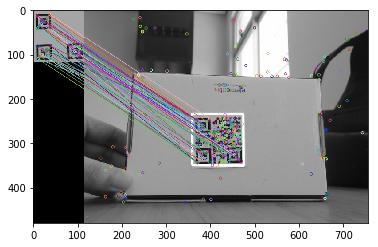

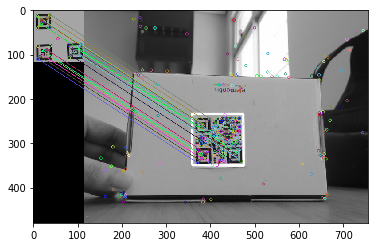

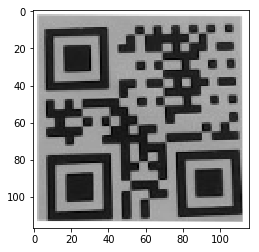

In [2]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt



imL = cv2.imread('images/fb.png',0) # sem reduzir não funcionou bem: escala muito difer.
imR = cv2.imread('images/best.jpg',0)

sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(imL,None)
kp2, des2 = sift.detectAndCompute(imR,None)

# FLANN ao invés de força bruta
flann = cv2.FlannBasedMatcher() # Default KDTREE. Permite mudar algoritmo e parâmetros dos algoritmos (ver doc).
matches = flann.knnMatch(des1,des2,k=2)

# Seleciona os vizinhos com melhor razão de distância comparado com o 2o vizinho (como explicado nos slides)
good = []
for m,n in matches:
    if m.distance < 0.85*n.distance:
        good.append(m)
        
# Extrai as posições dos keypoints das duas imagens correspondentes aos pontos no vetor 'good'
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist() # inliers

# Aplica a homografia nos pontos extremos de imL (controle remoto), encontrando suas posições em imR
h,w = imL.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
print(np.int32(dst))
# Desenha polígono em imR entre os pontos transformados
imR = cv2.polylines(imR,[np.int32(dst)],True,255,3, cv2.LINE_AA)
img3 = cv2.drawMatches(imL,kp1,imR,kp2,good,None)



plt.imshow(img3, 'gray'); plt.show()

img3 = cv2.drawMatches(imL,kp1,imR,kp2,good,None,matchesMask = matchesMask)
plt.imshow(img3, 'gray'); plt.show()


QRperspec = cv2.getPerspectiveTransform(np.float32(dst),pts)
found = cv2.warpPerspective(imR,QRperspec,(w,h))
plt.imshow(found, 'gray'); plt.show()

